# ABS Detailed Labour Force 6291

## Python set-up

In [1]:
# analytic imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import readabs as ra
from readabs import metacol as mc

# local imports
from abs_helper import get_abs_data
from abs_summary_plot import plot_summary
from plotting import line_plot, finalise_plot

# pandas display settings
pd.options.display.max_rows = 99999
pd.options.display.max_columns = 999

# show charts within this notebook
SHOW = False

## Get data from ABS

In [2]:
abs_dict, meta, source, RECENT = get_abs_data("6291.0.55.001")
plot_times = None, RECENT
plot_tags = "", "-recent"

# Note quarterly data for periods ending Feb, May, Aug, Nov
print(f"Monthly updated to {abs_dict['6291001'].index[-1]}")
if "6291004" in abs_dict:
    print(f"Quarterly updated to {abs_dict['6291004'].dropna().index[-1]}")

Monthly updated to 2024-05
Quarterly updated to 2024Q2


## Plot

### Monthly by Age

In [3]:
def monthly_by_age() -> None:
    """Produce monthly by age charts."""

    table = "6291001"
    data = abs_dict[table]
    series_type = "Original"

    ages = [
        "15-24 years",
        "25-34 years",
        "35-44 years",
        "45-54 years",
        "55-64 years",
    ]

    token = "By Age"
    plots = [
        f"> {token} ;  Participation rate ;  Persons ;",
        f"> {token} ;  Unemployment rate ;  Persons ;",
    ]

    for plot in plots:
        combined = {}
        for age in ages:
            plot_desc = plot.replace(token, age)
            search = {
                plot_desc: mc.did,
                series_type: mc.stype,
                table: mc.table,
            }
            _table, ident, units = ra.find_abs_id(meta, search)
            combined[age] = data[ident]
        combined, units = ra.recalibrate(pd.DataFrame(combined), units)

        title = f"Australia: {plot}"
        line_plot(
            combined,
            title=title,
            ylabel=units,
            rfooter=f"{source} {table}",
            lfooter=f"{series_type.capitalize()} series",
            show=SHOW,
        )


monthly_by_age()

### Quarterly by sector

In [4]:
def quarterly_by_sector() -> None:
    """Produce quarterly by sector charts."""

    QSHOW = False
    table = "6291004"
    data_table = abs_dict[table]
    series_type = "Seasonally Adjusted"
    selection = meta[(meta["Series Type"] == series_type) & (meta["Table"] == table)]

    # summary of most recent growth rates by sector ...
    labels = selection[mc.did].str.split(" ; ").str[0]
    series_ids = selection.loc[labels.index, mc.id]
    for period, title in zip([1, 4], ["Q/Q", "Y/Y"]):
        required = {k: [v, period] for k, v in zip(labels, series_ids)}
        reversed = {v[0]: k for k, v in required.items()}
        plot_summary(
            required,
            abs_dict,
            meta,
            start="2000Q1",
            title=f"{title} Growth: # Employed by Sector {data_table.index[-1]}",
            rfooter=source,
            lfooter=f"Australia. {series_type.capitalize()} series. "
            + "All data is Q/Q percentage growth. ",
            show=QSHOW,
        )

    # growth paths over the past 10 years ...
    # note - removed economy as a whole
    years, qs_per_year = 10, 4
    start = data_table.index[-1] - (years * qs_per_year)
    data = (
        data_table.loc[start:, series_ids[:-1]]
        .rename(columns=reversed)
        .sort_index(ascending=True, axis=1)
    )
    data_index = (data / data.iloc[0] * 100.0).dropna()
    line_plot(
        data_index,
        title=f"Index of Number Employed by Sector (100={start})",
        ylabel=f"Index (100={start})",
        rfooter=source,
        lfooter=f"Australia. {series_type.capitalize()} series. ",
        legend={"loc": "upper left", "ncol": 2, "fontsize": 6},
        style=["-", "--", "-.", ":"],
        axhline={"y": 100, "color": "#555555", "linewidth": 0.66, "linestyle": "-"},
        width=1.5,
        show=QSHOW,
    )

    # employment numbers in each sector ...
    data = data[data.columns[::-1]]
    labels, series = data.columns, data.iloc[-1]
    series, units = ra.recalibrate(series, "Thousands")
    fig, ax = plt.subplots()
    ax.barh(
        labels,
        series,
        color="skyblue",
        edgecolor="black",
    )
    finalise_plot(
        ax,
        title=f"Num. Employed by Sector at {data_table.index[-1]}",
        ylabel=None,
        xlabel=units,
        lfooter=f"Australia. {series_type.capitalize()} series. ",
        axvline={"x": 0, "color": "#555555", "linewidth": 0.66, "linestyle": "-"},
        rfooter=source,
        show=QSHOW,
    )

    # individual sector plots for number employed ...
    for _, series in selection.iterrows():
        title = series["Data Item Description"].replace(" ;", "").replace("  ", " ")
        series_id, units = series["Series ID"], series["Unit"]
        series, units = ra.recalibrate(data_table[series_id], units)
        line_plot(
            series,
            title=title,
            ylabel=units,
            rfooter=source,
            lfooter=f"Australia. {series_type.capitalize()} series. ",
            show=QSHOW,
        )


quarterly_by_sector()

Overriding x0: True
Overriding x0: True


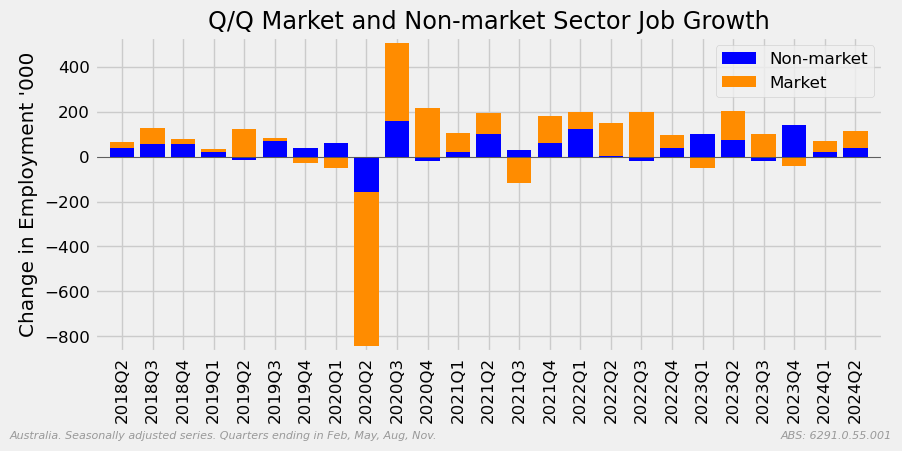

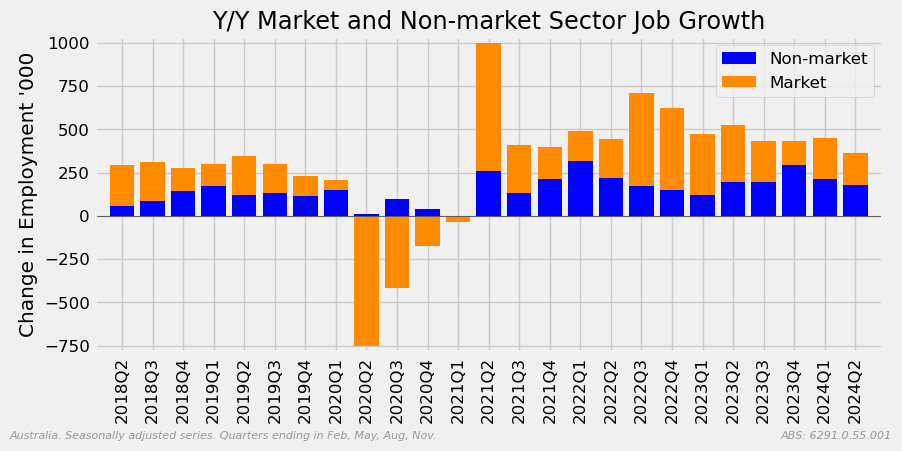

In [5]:
def job_growth_by_market_sector():

    table = "6291004"
    data_table = abs_dict[table]
    series_type = "Seasonally Adjusted"
    selection = meta[(meta["Series Type"] == series_type) & (meta["Table"] == table)]
    labels = selection[mc.did].str.split(" ; ").str[0]
    series_ids = selection.loc[labels.index, mc.id]

    data = data_table.loc[:, series_ids[:-1]].rename(columns=labels)

    # growth by market sector ...
    non_market = [
        "Public Administration and Safety",
        "Education and Training",
        "Health Care and Social Assistance",
    ]

    for p, title in zip([1, 4], ["Q/Q", "Y/Y"]):
        nm_jobs = data[non_market].sum(axis=1)
        m_jobs = data.loc[:, ~data.columns.isin(non_market)].sum(axis=1)
        nm_growth = nm_jobs.diff(p).dropna()
        m_growth = m_jobs.diff(p).dropna()
        m_data = pd.DataFrame({"Non-market": nm_growth, "Market": m_growth})
        N = 25
        ax = m_data.iloc[-N:].plot.bar(
            stacked=True, width=0.8, color=["blue", "darkorange"]
        )

        finalise_plot(
            ax,
            title=f"{title} Market and Non-market Sector Job Growth",
            ylabel="Change in Employment '000",
            rfooter=source,
            lfooter=f"Australia. {series_type.capitalize()} series. "
            + "Quarters ending in Feb, May, Aug, Nov. ",
            y0=True,
            show=True,
        )

    # growth paths over the past N years ...
    N = 25  # quarters
    nm_index = nm_jobs / nm_jobs.iloc[-N] * 100.0
    m_index = m_jobs / m_jobs.iloc[-N] * 100.0
    m_data = pd.DataFrame({"Non-market": nm_index, "Market": m_index})
    line_plot(
        m_data.iloc[-N:],
        title=f"Index of Market and Non-market Sector Employment (100={m_data.index[-N]})",
        ylabel=f"Index (100={m_data.index[-N]})",
        rfooter=source,
        lfooter=f"Australia. {series_type.capitalize()} series. ",
        legend={"loc": "upper left", "ncol": 2, "fontsize": 9},
        style=["-", "--", "-.", ":"],
        axhline={"y": 100, "color": "#555555", "linewidth": 0.66, "linestyle": "-"},
        width=1.5,
        show=SHOW,
    )


job_growth_by_market_sector()

### Monthly by duration of unemployment

In [6]:
def monthly_by_ue_duration() -> None:
    """Produce monthly UE duration charts."""

    table = "6291014a"
    df = abs_dict[table]
    series_type = "Original"

    cohorts = [
        "2 years and over",
        "1-2 years",
        "6-12 months",
        "3-6 months",
        "1-3 months",
        "under 1 month",
    ]

    categories = ["Unemployed total ;  Persons ;"]
    period = 12
    for category in categories:
        raw = pd.DataFrame()
        trend = pd.DataFrame()
        for cohort in cohorts:
            rows = meta[
                meta[mc.did].str.contains(category) & meta[mc.did].str.contains(cohort)
            ]
            assert len(rows) == 1
            select = rows["Series ID"].values[0]
            units = rows["Unit"].values[0]
            raw[cohort] = df[select]
            trend[cohort] = df[select].rolling(period).mean()

        title = (
            category.replace(" ; ", " ").replace(" ;", " ").replace("  ", " ").title()
        )
        lfooter = f"Australia. {series_type.capitalize()} series. "

        trend, u = ra.recalibrate(trend, units)
        raw, u = ra.recalibrate(raw, units)
        for data, t in zip([raw, trend], [title, f"{title}, {period} month ave."]):
            line_plot(
                data,
                title=t,
                ylabel=u,
                rfooter=f"{source} {table}",
                lfooter=lfooter,
                width=1.5,
                show=SHOW,
            )


monthly_by_ue_duration()

## Finished

In [7]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Tue Jul 16 2024 09:34:08

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

pandas    : 2.2.2
readabs   : 0.0.10a4
numpy     : 1.26.4
matplotlib: 3.9.1

Watermark: 2.4.3



In [8]:
print("Finished")

Finished
